# Neural Machine Translation Tutorial
---

Paper Implementation: [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473) - Dzmitry Bahdanau, Kyunghyun Cho, Yoshua Bengio (v7 2016)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.ticker as ticker
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

---

## 신경망 번역기의 목적

소스(source)문장을 타겟(target)문장으로 변환하는 것

Examples:

|source|target|
|--|--|
| Nice to meet you| 만나서 반갑습니다 |
| I am very happy to meet you | 만나서 참 반가워요| 

In [3]:
flatten = lambda d: [t for s in d for t in s]

def build_vocab(data, start_tkn=False):
    """build vocabulary"""
    if start_tkn:
        vocab = {'<unk>': 0, '<pad>': 1, '<s>': 2, '</s>': 3}
    else:
        vocab = {'<unk>': 0, '<pad>': 1}
    
    words = set(flatten(data))
    for t in words:
        if vocab.get(t) is None:
            vocab[t] = len(vocab) 
    return vocab

def add_pad(data, start_tkn=False):
    """add padding of sentences in batch to match lenghts"""
    if start_tkn:
        data = [['<s>'] + sent + ['</s>'] for sent in data]
    max_len = max([len(sent) for sent in data])
    data = [sent + ['<pad>']*(max_len-len(sent)) if len(sent) < max_len else sent \
            for sent in data ]
    return data

def numericalize(data, vocab):
    """numericalize and turn them into tensor"""
    f = lambda x: [vocab.get(t) if vocab.get(t) is not None else vocab.get('<unk>') for t in x]
    data = list(map(f, data))
    return data

def preprocess(data, vocab, start_tkn=False):
    data = add_pad(data, start_tkn=start_tkn)
    data = numericalize(data, vocab)
    # 텐서플로우는 아래 부분을 수정해야할겁니다. torch.LongTensor 를 제거하고 data 로만 두시고
    # 숫자로 치환된 data 를 numpy array 로 출력하신 다음에 진행하면 될것 같습니다. 
    return torch.LongTensor(data)  

def build_batch(src, trg, src_vocab, trg_vocab, is_sort=False):
    if is_sort:
        sorted_data = sorted(list(zip(src, trg)), key=lambda x: len(x[0]), reverse=True)
        src, trg = list(zip(*sorted_data))
    src = preprocess(src, src_vocab, start_tkn=False)
    trg = preprocess(trg, trg_vocab, start_tkn=True)
    if is_sort:
        return (src, src.ne(src_vocab.get('<pad>')).sum(1)), trg
    return src, trg

In [4]:
dataset = """Nice to meet you > 만나서 반가워요 \n I am very happy to meet you > 만나서 참 반가워요""".splitlines()
dataset = [s.strip().split('>') for s in dataset]
src, trg = [[sent.split() for sent in x] for x in zip(*dataset)]
src_vocab = build_vocab(src)
trg_vocab = build_vocab(trg, start_tkn=True)
(inputs, lengths), targets = build_batch(src, trg, src_vocab, trg_vocab, is_sort=True)

In [5]:
inputs

tensor([[4, 8, 3, 9, 2, 7, 5],
        [6, 2, 7, 5, 1, 1, 1]])

In [6]:
lengths

tensor([7, 4])

In [7]:
targets

tensor([[2, 6, 4, 5, 3],
        [2, 6, 5, 3, 1]])

## Hyperparameters for Encoder

In [94]:
EMBED = 20  # embedding_size
HIDDEN = 60  # hidden_size
ENC_N_LAYER = 3  # encoder number of layers
L_NORM = True  # whether to use layernorm

## Encoder

In [95]:
class Encoder(nn.Module):
    """Encoder"""
    def __init__(self, vocab_size, embed_size, hidden_size, n_layers, layernorm=False, bidirec=False):
        super(Encoder, self).__init__()        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_direction = 2 if bidirec else 1
        self.layernorm = layernorm
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, n_layers, bidirectional=bidirec, 
                          batch_first=True)
        if layernorm:
            self.l_norm = nn.LayerNorm(embed_size)
        
    def forward(self, inputs, lengths):
        """
        Inputs:
        - inputs: B, T_e
        - lengths: B, (list)
        Outputs:
        - outputs: B, T_e, n_directions*H
        - hiddens: 1, B, n_directions*H
        """
        assert isinstance(lengths, list), "lengths must be a list type"
        # B: batch_size, T_e: enc_length, M: embed_size, H: hidden_size
        inputs = self.embedding(inputs) # (B, T_e) > (B, T_e, m)
        if self.layernorm:
            inputs = self.l_norm(inputs)
        
        packed_inputs = pack_padded_sequence(inputs, lengths, batch_first=True)
        # packed_inputs: (B*T_e, M) + batches: (T_e)
        packed_outputs, hiddens = self.gru(packed_inputs)
        # packed_outputs: (B*T_e, n_directions*H) + batches: (T_e)
        # hiddens: (n_layers*n_directions, B, H)
        outputs, outputs_lengths = pad_packed_sequence(packed_outputs, batch_first=True)
        # output: (B, T_e, n_directions*H) + lengths (B)
        hiddens = torch.cat([h for h in hiddens[-self.n_direction:]], 1).unsqueeze(0)
        # hiddens: (1, B, n_directions*H)
        return outputs, hiddens

In [96]:
encoder = Encoder(len(src_vocab), EMBED, HIDDEN, ENC_N_LAYER, L_NORM, bidirec=True)

In [97]:
enc_output, enc_hidden = encoder(inputs, lengths.tolist())
enc_output.size(), enc_hidden.size()

(torch.Size([2, 7, 120]), torch.Size([1, 2, 120]))

## Decoder

In [10]:
dec_embedding = nn.Embedding(len(TRG.vocab), config.EMBED).to(DEVICE)
sos = torch.LongTensor([2]*32).unsqueeze(1).to(DEVICE)
dec_input = dec_embedding(sos)
dec_input.size()

torch.Size([32, 1, 256])

### Attention

In [11]:
class Attention(nn.Module):
    """Attention"""
    def __init__(self, hidden_size, method='general', device='cpu'):
        super(Attention, self).__init__()
        """
        * hidden_size: decoder hidden_size(H_d=encoder_gru_direction*H)
        methods:
        - 'dot': dot product between hidden and encoder_outputs
        - 'general': encoder_outputs through a linear layer 
        - 'concat': concat (hidden, encoder_outputs) ***NOT YET***
        - 'paper': concat + tanh ***NOT YET***
        """
        self.method = method
        self.device = device
        self.hidden_size = hidden_size 
        if self.method == 'general':
            self.linear = nn.Linear(hidden_size, hidden_size)

    def forward(self, hiddens, enc_outputs, enc_lengths=None, return_weight=False):
        """
        Inputs:
        - hiddens(previous_hiddens): B, 1, H_d
        - enc_outputs(enc_outputs): B, T_e, H_d
        - enc_lengths: real lengths of encoder outputs
        - return_weight = return weights(alphas)
        Outputs:
        - contexts: B, 1, H_d
        - attns: B, 1, T_e
        """
        hid, out = hiddens, enc_outputs
        # Batch(B), Seq_length(T)
        B, T_d, H = hid.size()
        B, T_e, H = out.size()
        
        score = self.get_score(hid, out)
        # score: B, 1, T_e
        if enc_lengths is not None:
            mask = self.get_mask(B, T_d, T_e, enc_lengths)  # masks: B, 1, T_e
            score = score.masked_fill(mask, float('-inf'))
        
        attns = torch.softmax(score, dim=2)  # attns: B, 1, T_e
        contexts = attns.bmm(out)
        if return_weight:
            return contexts, attns
        return contexts
            
    def get_score(self, hid, out):
        """
        Inputs:
        - hid(previous_hiddens): B, 1, H_d 
        - out(enc_outputs): B, T_e, H_d
        Outputs:
        - 
        """
        if self.method == 'dot':
            # bmm: (B, 1, H_d) * (B, H, T_e) = (B, 1, T_e)
            score = hid.bmm(out.transpose(1, 2))
            return score
        
        elif self.method == 'general':
            # linear: (B, T_e, H_d) > (B, T_e, H_d)
            # bmm: (B, 1, H_d) * (B, H_d, T_e) = (B, 1, T_e)
            score = self.linear(out)
            score = hid.bmm(score.transpose(1, 2))
            return score

    def get_mask(self, B, T_d, T_e, lengths):
        assert isinstance(lengths, list), "lengths must be list type"
        mask = torch.zeros(B, T_d, T_e, dtype=torch.uint8).to(self.device)
        for i, x in enumerate(lengths):
            if x < T_e:
                mask[i, :, x:].fill_(1)
        return mask

In [12]:
enc_direc = 2
attention = Attention(enc_direc*config.HIDDEN, method='general', device=DEVICE).to(DEVICE)
contexts, attns = attention(enc_hidden.transpose(0,1), 
                            enc_output, lengths.tolist(), return_weight=True)
contexts.size(), attns.size()

(torch.Size([32, 1, 1024]), torch.Size([32, 1, 30]))

### Decoder model

In [13]:
class Decoder(nn.Module):
    """Decoder"""
    def __init__(self, vocab_size, embed_size, hidden_size, n_layers=1, sos_idx=2, drop_rate=0.0, layernorm=False, method='general', teacher_force=False, device='cpu', return_w=False):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.device = device
        self.sos_idx = sos_idx
        self.return_w = return_w
        self.teacher_force = teacher_force
        self.layernorm = layernorm
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(drop_rate)
        self.attention = Attention(hidden_size, method=method, device=device)
        self.gru = nn.GRU(embed_size+hidden_size, hidden_size, n_layers, bidirectional=False, 
                          batch_first=True)
        self.linear = nn.Linear(2*hidden_size, vocab_size)
        if layernorm:
            self.l_norm = nn.LayerNorm(embed_size)
    
    def start_token(self, batch_size):
        sos = torch.LongTensor([self.sos_idx]*batch_size).unsqueeze(1).to(self.device)
        return sos
    
    def init_hiddens(self, batch_size):
        return torch.zeros(batch_size, self.n_layers, self.hidden_size).to(self.device)
    
    def forward(self, hiddens, enc_output, enc_lengths=None, max_len=None, targets=None, 
                is_eval=False, is_test=False, stop_idx=3):
        """
        * H_d: decoder hidden_size = encoder_gru_directions * H
        * M_d: decoder embedding_size
        Inputs:
        - hiddens: last encoder hidden at time 0 = 1, B, H_d 
        - enc_output: encoder output = B, T_e, H_d
        - enc_lengths: encoder lengths = B
        - max_len: max lenghts of target = T_d
        Outputs:
        - scores: results of all predictions = B*T_d, vocab_size
        - attn_weights: attention weight for all batches = B, T_d, T_e
        """
        if is_test:
            is_eval=True
        inputs = self.start_token(hiddens.size(1))  # (B, 1)
        inputs = self.embedding(inputs) # (B, 1, M_d)
        if self.layernorm:
            inputs = self.l_norm(inputs)
        inputs = self.dropout(inputs)
        # match layer size: (1, B, H_d) > (n_layers, B, H_d)
        if hiddens.size(0) != self.n_layers:
            hiddens = hiddens.repeat(self.n_layers, 1, 1)
        # prepare for whole target sentence scores
        scores = []  
        attn_weights = []
        for i in range(1, max_len):
            # contexts[c{i}] = alpha(hiddens[s{i-1}], encoder_output[h])
            # select last hidden: (1, B, H_d) > transpose: (B, 1, H_d) > attention
            contexts = self.attention(hiddens[-1:, :].transpose(0, 1), enc_output, enc_lengths, 
                                      return_weight=self.return_w)
    
            if self.return_w:
                attns = contexts[1]  # attns: (B, seq_len=1, T_e) 
                contexts = contexts[0]  # contexts: (B, seq_len=1, H_d)
                attn_weights.append(attns)
                
            # gru_inputs = concat(embeded_token[y{i-1}], contexts[c{i}]): (B, seq_len=1, H_d+M_d)
            gru_inputs = torch.cat((inputs, contexts), 2)
            
            # gru: s{i} = f(gru_inputs, s{i-1})
            # (B, 1, M_d+H_d) > (n_layers, B, H_d)
            _, hiddens = self.gru(gru_inputs, hiddens)            
            
            # scores = g(s{i}, c{i})
            # select last hidden: (1, B, H_d) > transpose: (B, 1, H_d) > concat: (B, 1, H_d + H_d) >
            # output linear : (B, seq_len=1, vocab_size)
            score = self.linear(torch.cat((hiddens[-1:, :].transpose(0, 1), contexts), 2))
            scores.append(score)
    
            if (self.teacher_force and not is_eval):
                selected_targets = targets[:, i].unsqueeze(1)
            else:
                selected_targets = None
            
            inputs, stop_decode = self.decode(is_tf=self.teacher_force, 
                                              is_eval=is_eval,
                                              is_test=is_test,
                                              score=score, 
                                              targets=selected_targets, 
                                              stop_idx=stop_idx)
            if stop_decode:
                break
            
        scores = torch.cat(scores, 1).view(-1, self.vocab_size)  # (B, T_d, vocab_size) > (B*T_d, vocab_size)
        if self.return_w:
            return scores, torch.cat(attn_weights, 1)  # (B, T_d, T_e)
        return scores
    
    def decode(self, is_tf, is_eval, is_test, score, targets, stop_idx):
        """
        - for validation: if is_tf, set 'is_eval' True, else False
        - for test evaluation: set 'is_tf' False and set 'is_eval' True
        """
        stop_decode = False
        if is_test:
            # test
            preds = score.max(2)[1]
            if preds.view(-1).item() == stop_idx:
                stop_decode = True
            inputs = self.embedding(preds)
        else:
            # train & valid
            if is_tf and not is_eval:
                assert targets is not None, "target must not be None in teacher force mode"
                inputs = self.embedding(targets)
            else:
                preds = score.max(2)[1]
                inputs = self.embedding(preds)

        if self.layernorm:
            inputs = self.l_norm(inputs)
        inputs = self.dropout(inputs)
        return inputs, stop_decode

In [20]:
decoder = Decoder(len(TRG.vocab), config.EMBED, encoder.n_direction*config.HIDDEN, n_layers=config.DEC_N_LAYER,
                  drop_rate=config.DROP_RATE, method=config.METHOD, layernorm=config.L_NORM, 
                  sos_idx=TRG.vocab.stoi['<s>'], teacher_force=config.TF, 
                  return_w=config.RETURN_W, device=DEVICE).to(DEVICE)

In [21]:
o= decoder(hiddens=enc_hidden, enc_output=enc_output, max_len=targets.size(1),
               targets=targets)
o.size()

torch.Size([992, 41652])

---

In [14]:
# loss_function = nn.NLLLoss(ignore_index=TRG.vocab.stoi['<pad>'])
loss_function = nn.CrossEntropyLoss(ignore_index=TRG.vocab.stoi['<pad>'])

enc_optimizer = optim.Adam(encoder.parameters(), 
                               lr=config.LR, 
                               weight_decay=config.LAMBDA)
dec_optimizer = optim.Adam(decoder.parameters(), 
                           lr=config.LR * config.DECLR, 
                           weight_decay=config.LAMBDA)
enc_scheduler = optim.lr_scheduler.MultiStepLR(gamma=0.1,
                                               milestones=[int(config.STEP / 4), 
                                                           int(config.STEP / 2),
                                                           int(3 * config.STEP / 4)],
                                               optimizer=enc_optimizer)
dec_scheduler = optim.lr_scheduler.MultiStepLR(gamma=0.1,
                                               milestones=[int(config.STEP / 4), 
                                                           int(config.STEP / 2),
                                                           int(3 * config.STEP / 4)],
                                               optimizer=dec_optimizer)

In [15]:
loss = loss_function(o, targets[:, 1:].contiguous().view(-1))
loss

tensor(10.6426, grad_fn=<NllLossBackward>)

In [56]:
def run_step(enc, dec, loader, loss_function, enc_optimizer, dec_optimizer):
    enc.train()
    dec.train()
    losses = []
    for i, batch in enumerate(loader):
        inputs, lengths = batch.src
        targets = batch.trg

        enc.zero_grad()
        dec.zero_grad()
        
        enc_output, enc_hidden = enc(inputs, lengths.tolist())
        outputs = dec(enc_hidden, enc_output, lengths.tolist(), 
                      targets.size(1), targets, is_eval=False)
        loss = loss_function(outputs, targets[:, 1:].contiguous().view(-1))
        losses.append(loss.item())
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(enc.parameters(), 50.0)  # gradient clipping
        torch.nn.utils.clip_grad_norm_(dec.parameters(), 50.0)  # gradient clipping
        
        enc_optimizer.step()
        dec_optimizer.step()
        print(' > [{}/{}] train_loss {:.4f}'.format(i, len(loader), loss.item()))
    return np.mean(losses)

In [57]:
run_step(encoder, decoder, train_loader, loss_function, enc_optimizer, dec_optimizer)

 > [0/11839] train_loss 10.3431


10.34306812286377

---

In [1]:
import sys
import os
sys.path.append(os.getcwd() + '/model')
print([d for d in os.listdir(path='./model') if '.sh' in d])

['runtrain_loaded2.sh', 'runtrain_loaded.sh', 'runtrain.sh', 'runtrain_wmt.sh']


In [2]:
%run ./model/build_config.py -r "./model/runtrain_loaded2.sh" -c "./model/settings.py" -n

import torch
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.ticker as ticker
import settings
from train import import_data, build_model, validation
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
# DEVICE = 'cuda' if config.USE_CUDA else 'cpu'
DEVICE = None

done!


In [3]:
SRC, TRG, train, _, test, _, _, test_loader = import_data(config=settings, device=DEVICE, is_test=True)
enc, dec, loss_function, *_ = build_model(config=settings, src_field=SRC, trg_field=TRG, device=DEVICE)

Source Language: 40781 words, Target Language: 26320 words
Training Examples: 160477, Validation Examples: 776
Building Model ...


In [4]:
enc.load_state_dict(torch.load(settings.SAVE_ENC_PATH))
dec.load_state_dict(torch.load(settings.SAVE_DEC_PATH))

In [5]:
print("test loss is {:.4f}".format(validation(settings, enc, dec, test_loader, loss_function)))

test loss is 5.8170


In [6]:
def evaluate(test_data, max_len, src_field, trg_field, stop_token='</s>'):
    f = lambda x: trg_field.vocab.itos[x]
    test_ex = np.random.choice(test_data.examples)
    src_sent = test_ex.src
    trg_sent = test_ex.trg
    inputs, lengths = src_field.numericalize(([src_sent], [len(src_sent)]))
    enc_output, enc_hidden = enc(inputs, lengths.tolist())
    outputs, attns = dec.forward(enc_hidden, enc_output, lengths.tolist(), max_len, 
                                 targets=None, is_test=True, 
                                 stop_idx=trg_field.vocab.stoi[stop_token])
    preds = outputs.max(1)[1]
    translated = list(map(f, preds.tolist()))
    
    print(" < input: {}".format(' '.join(src_sent)))
    print(" > target: {}".format(' '.join(trg_sent)))
    print(" > predict: {}".format(' '.join(translated[:-1])))
    return attns.squeeze(0).detach(), (src_sent, trg_sent, translated)

In [7]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence + ['</s>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [8]:
def eval_showattns(test_data, max_len, src_field, trg_field, stop_token='</s>'):
    attns, pairs = evaluate(test_data, max_len, src_field=src_field, trg_field=trg_field, stop_token=stop_token)
    show_attention(input_sentence=pairs[0], output_words=pairs[2], attentions=attns)

 < input: es gibt so viele gründe , warum männer ihre stimme erheben müssen .
 > target: so there 's so many reasons why we need men to speak out .
 > predict: there 's so many reasons why men have to say their voice .


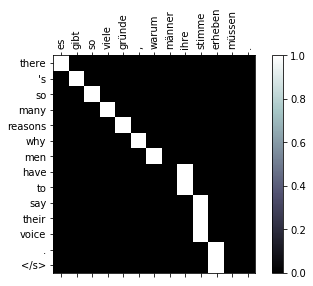

In [9]:
eval_showattns(train, settings.MAX_LEN, SRC, TRG)

 < input: und als ich schließlich begann , ägyptologie zu studieren , wurde mir klar , dass das sehen mit meinen bloßen augen nicht ausreichte .
 > target: and eventually when i started studying egyptology , i realized that seeing with my naked eyes alone was n't enough .
 > predict: and when i finally started to study , i realized that this was really <unk> that i see that my eyes were not <unk> .


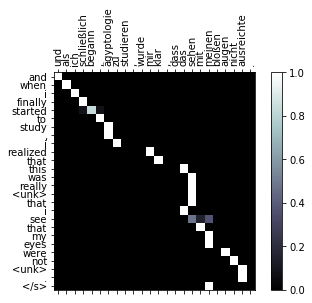

In [9]:
eval_showattns(test, settings.MAX_LEN, SRC, TRG)